# Behavioral analyses

This notebook shows basic behavioral figures and the statistical models for the following paper:

Waskom ML, Asfour JW, Kiani R (2018). [Perceptual insensitivity to higher-order statistical moments of coherent random dot motion](http://jov.arvojournals.org/article.aspx?articleid=2685931). *Journal of Vision* 18(6):9 1-10.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.regression.linear_model import OLS
from statsmodels.discrete.discrete_model import Logit
from statsmodels.tools import add_constant 

In [2]:
%matplotlib inline
sns.set(style="whitegrid", font_scale=1.3, color_codes=True)

----

## Load the data and define how the figures will look

In [3]:
trial_data = pd.read_csv("trial_data.csv")

In [4]:
subject_order = ["S1", "S2", "S3", "S4", "S5"]

condition_order = [
    "N", "M5", "M10", "M15", "M25",
    "SL8", "SL6", "SR6", "SR8",
    "K", "KV", "V",
]

condition_palette = dict(
    N="#919191",
    M5="#7e8981",
    M10="#6c8172",
    M15="#5a7964",
    M25="#3a684a",
    SL8="#937149",
    SL6="#ab8b6a",
    SR6="#ab8b6a",
    SR8="#937149",
    V="#a94c62",
    KV="#68519e",
    K="#5478ae",
)

----

## Odd patch detection accuracy in each condition

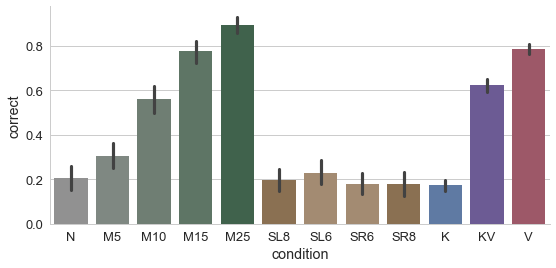

In [5]:
sns.factorplot(x="condition", y="correct",
               data=trial_data,
               kind="bar",
               palette=condition_palette,
               order=condition_order,
               size=4, aspect=2)

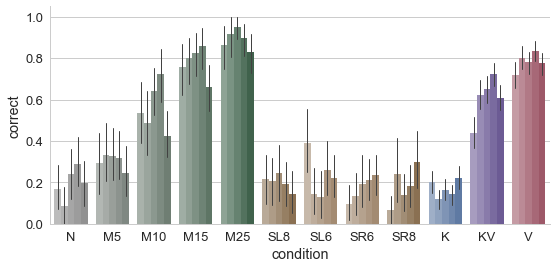

In [6]:
f, ax = plt.subplots(figsize=(8, 4))
for c, cond_data in trial_data.groupby("condition"):
    pal = sns.light_palette(condition_palette[c], 10)[-5:]
    sns.barplot(x="condition", y="correct", hue="subject",
                data=cond_data,
                palette=pal, ci=95, errwidth=1,
                order=condition_order,
                hue_order=subject_order,
                ax=ax)
ax.legend_ = None
sns.despine()
f.tight_layout()

## Odd patch reaction time in each condition

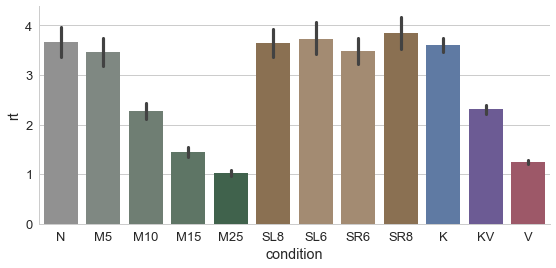

In [7]:
sns.factorplot(x="condition", y="rt",
               data=trial_data,
               kind="bar",
               palette=condition_palette,
               order=condition_order,
               size=4, aspect=2)

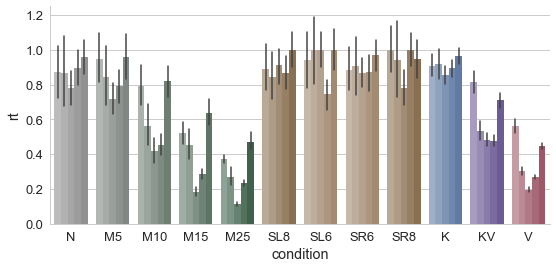

In [8]:
trial_data_norm = trial_data.copy()
for subj, subj_trial_data in trial_data.groupby("subject"):
    subj_norm_rt = subj_trial_data.rt / subj_trial_data.groupby("condition").rt.mean().max()
    trial_data_norm.loc[trial_data_norm.subject == subj, "rt"] = subj_norm_rt

f, ax = plt.subplots(figsize=(8, 4))
for c, cond_data in trial_data_norm.reset_index().groupby("condition"):
    pal = sns.light_palette(condition_palette[c], 10)[-5:]
    sns.barplot(x="condition", y="rt", hue="subject",
                data=cond_data,
                palette=pal,
                ci=95, errwidth=1.5,
                order=condition_order,
                hue_order=subject_order,
                ax=ax)
ax.legend_ = None
sns.despine()
f.tight_layout()

# Tables of detection accuracy and reaction time

In [9]:
(trial_data
 .groupby("condition")
 .mean()
 .loc[:, ["correct", "rt"]]
 .reindex(condition_order)
 .round(2)
 .T)

condition,N,M5,M10,M15,M25,SL8,SL6,SR6,SR8,K,KV,V
correct,0.21,0.30,0.56,0.78,0.89,0.20,0.23,0.18,0.18,0.17,0.62,0.79
rt,3.66,3.46,2.27,1.45,1.03,3.64,3.73,3.49,3.85,3.61,2.31,1.25


In [10]:
(trial_data
 .groupby(["subject", "condition"])
 .mean()
 .loc[:, ["correct", "rt"]]
 .unstack("subject")
 .reindex(condition_order)
 .round(2)
 .T)

condition           N    M5   M10   M15   M25   SL8   SL6   SR6   SR8     K  \
        subject                                                               
correct S1       0.17  0.29  0.54  0.76  0.86  0.21  0.39  0.09  0.07  0.20   
        S2       0.09  0.33  0.49  0.80  0.92  0.20  0.15  0.13  0.24  0.12   
        S3       0.24  0.33  0.64  0.83  0.95  0.24  0.13  0.19  0.14  0.16   
        S4       0.29  0.32  0.73  0.86  0.90  0.19  0.26  0.21  0.18  0.14   
        S5       0.20  0.24  0.43  0.66  0.83  0.15  0.22  0.24  0.30  0.22   
rt      S1       1.45  1.59  1.32  0.87  0.62  1.49  1.57  1.48  1.67  1.51   
        S2       2.70  2.63  1.75  1.41  0.84  2.63  3.11  2.82  2.93  2.85   
        S3       5.11  4.69  2.73  1.21  0.75  6.00  6.56  5.70  5.13  5.60   
        S4       5.33  4.69  2.68  1.69  1.39  5.14  4.43  5.16  5.94  5.30   
        S5       2.84  2.84  2.43  1.89  1.40  2.96  2.96  2.87  2.81  2.85   

condition          KV     V  
        subject              
correct S1       0.44  0.72  
        S2       0.62  0.80  
        S3       0.65  0.78  
        S4       0.73  0.84  
        S5       0.61  0.77  
rt      S1       1.36  0.94  
        S2       1.66  0.94  
        S3       3.17  1.28  
        S4       2.84  1.59  
        S5       2.10  1.33

----

## Logistic regression of accuracy on condition-wise motion statistics

In [11]:
sample_stats = ["odd_m", "odd_v", "odd_s", "odd_k"]
model_data = (trial_data[sample_stats]
              .groupby(trial_data["condition"])
              .transform("mean")
              .assign(odd_s=lambda x: x.odd_s.abs())
              .join(trial_data[["condition", "correct", "rt"]])
              .dropna())

In [12]:
X = add_constant(model_data[sample_stats])
Y = model_data["correct"]
m = Logit(Y, X).fit(disp=False)
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                correct   No. Observations:                 5349
Model:                          Logit   Df Residuals:                     5344
Method:                           MLE   Df Model:                            4
Date:                Fri, 11 May 2018   Pseudo R-squ.:                  0.2155
Time:                        14:56:01   Log-Likelihood:                -2906.9
converged:                       True   LL-Null:                       -3705.5
                                        LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.5349      0.198    -17.847      0.000      -3.923      -3.147
odd_m          0.1517      0.009     16.625      0.000       0.134       0.170
odd_v          0.1011      0.005     22.349      0.000       0.092       0.110
odd_s         -0.0730      0.100     -0.729      0.466      -0.269       0.123
odd_k          0.0307      0.035      0.880      0.379      -0.038       0.099
==============================================================================
"""

In [13]:
m.pvalues.astype(object).to_frame("p values").T

,const,odd_m,odd_v,odd_s,odd_k
p values,3.02712e-71,4.60223e-62,1.23658e-110,0.465984,0.378824


---

## Logistic regression of accuracy on trialwise skewness

In [14]:
trialwise_data = (trial_data[sample_stats]
                  .assign(odd_s=lambda x: x.odd_s.abs())
                  .join(trial_data[["condition", "correct", "rt"]])
                  .dropna())

In [15]:
s_trials = trialwise_data.condition.str.startswith("S")
X = add_constant(trialwise_data.loc[s_trials, sample_stats])
Y = trialwise_data.loc[s_trials, "correct"]
m = Logit(Y, X).fit(disp=False)
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                correct   No. Observations:                  923
Model:                          Logit   Df Residuals:                      918
Method:                           MLE   Df Model:                            4
Date:                Fri, 11 May 2018   Pseudo R-squ.:                 0.01447
Time:                        14:56:01   Log-Likelihood:                -451.61
converged:                       True   LL-Null:                       -458.24
                                        LLR p-value:                   0.01007
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.9847      4.021     -1.737      0.082     -14.866       0.897
odd_m          0.0766      0.110      0.697      0.486      -0.139       0.292
odd_v          0.2661      0.183      1.456      0.145      -0.092       0.624
odd_s         -0.1172      0.267     -0.439      0.661      -0.640       0.406
odd_k          1.0021      0.305      3.286      0.001       0.404       1.600
==============================================================================
"""

In [16]:
m.pvalues.astype(object).to_frame("p values").T

,const,odd_m,odd_v,odd_s,odd_k
p values,0.0823958,0.485808,0.145381,0.660546,0.00101662


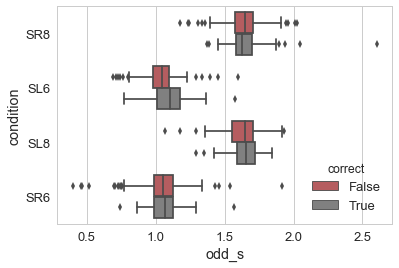

In [17]:
sns.boxplot(x="odd_s", y="condition", hue="correct",
            data=trialwise_data.loc[s_trials],
            palette=["r", ".5"])

## Logistic regression of accuracy on trialwise kurtosis

In [18]:
k_trials = trialwise_data.condition.str.startswith("K")
X = add_constant(trialwise_data.loc[k_trials, sample_stats])
Y = trialwise_data.loc[k_trials, "correct"]
m = Logit(Y, X).fit(disp=False)
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                correct   No. Observations:                 2014
Model:                          Logit   Df Residuals:                     2009
Method:                           MLE   Df Model:                            4
Date:                Fri, 11 May 2018   Pseudo R-squ.:                  0.1711
Time:                        14:56:02   Log-Likelihood:                -1130.4
converged:                       True   LL-Null:                       -1363.7
                                        LLR p-value:                 1.139e-99
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.1857      0.542     -9.563      0.000      -6.249      -4.123
odd_m          0.0134      0.050      0.266      0.791      -0.085       0.112
odd_v          0.1584      0.012     12.716      0.000       0.134       0.183
odd_s         -0.7351      0.329     -2.236      0.025      -1.379      -0.091
odd_k          0.1031      0.073      1.404      0.160      -0.041       0.247
==============================================================================
"""

In [19]:
m.pvalues.astype(object).to_frame("p values").T

,const,odd_m,odd_v,odd_s,odd_k
p values,1.14874e-21,0.790613,4.82173e-37,0.0253547,0.160367


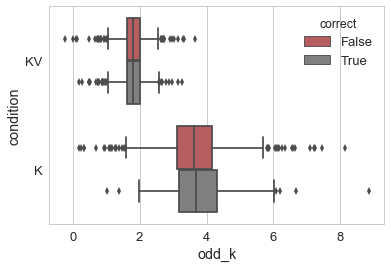

In [20]:
sns.boxplot(x="odd_k", y="condition", hue="correct",
            data=trialwise_data.loc[k_trials],
            palette=["r", ".5"])

---

## Linear regression of detection time on conditionwise statistics

In [21]:
X = add_constant(model_data[sample_stats])
Y = model_data["rt"]
m = OLS(Y, X).fit(disp=False)
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     rt   R-squared:                       0.256
Model:                            OLS   Adj. R-squared:                  0.255
Method:                 Least Squares   F-statistic:                     459.1
Date:                Fri, 11 May 2018   Prob (F-statistic):               0.00
Time:                        14:56:02   Log-Likelihood:                -10538.
No. Observations:                5349   AIC:                         2.109e+04
Df Residuals:                    5344   BIC:                         2.112e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.4407      0.141     38.619      0.000       5.165       5.717
odd_m         -0.1143      0.005    -21.254      0.000      -0.125      -0.104
odd_v         -0.0840      0.003    -26.402      0.000      -0.090      -0.078
odd_s          0.0544      0.070      0.774      0.439      -0.083       0.192
odd_k         -0.0211      0.025     -0.841      0.400      -0.070       0.028
==============================================================================
Omnibus:                      802.008   Durbin-Watson:                   1.275
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1328.235
Skew:                           1.006   Prob(JB):                    3.78e-289
Kurtosis:                       4.383   Cond. No.                         212.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [22]:
m.pvalues.astype(object).to_frame("p values").T

,const,odd_m,odd_v,odd_s,odd_k
p values,5.44008e-288,2.65293e-96,1.71787e-144,0.439127,0.400469
